# K-NEAREST NEIGHBORS

## Loading libraries and data

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## [1.2] Stemming, stop-word removal and Lemmatization.

In [10]:

# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'it', 'both', 'such', "you've", 'very', 'shan', 'all', 'yourself', 'who', 'weren', 'himself', "should've", 'few', 'against', 'his', 'as', 'some', "didn't", 'didn', 'in', "mightn't", 'an', 'own', 'now', 'which', 'being', 'its', 'd', "shan't", 'the', "wasn't", 'when', "doesn't", 'before', 'through', 'themselves', 'we', 'were', 'where', 's', 'y', 'or', 'mightn', 'wouldn', 'too', "she's", "you'd", 'be', 'and', 'again', 'those', 'then', "weren't", "you're", 't', 'over', 'been', 'until', 'she', 'each', "shouldn't", 'at', "won't", "couldn't", 'having', 'during', 'are', 'couldn', 'that', 'their', 'into', 'on', 'there', 'herself', 'itself', 'whom', 'this', 'off', 'should', 'have', 'by', 're', 'if', 'myself', 'from', 'up', 'shouldn', 'doesn', "mustn't", 'to', 'doing', 'only', 'll', 'i', 'needn', 'no', 'ain', 'while', 'can', "hasn't", 'under', 'ours', 'our', "haven't", "don't", 'not', 'ourselves', 'just', 'below', 'him', 'her', 'nor', "it's", 'here', 'but', 'further', 'they', 'do', 'wasn', "woul

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364173/364173 [09:10<00:00, 662.00it/s]


In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
final.to_pickle("./preprocessed.pkl")

# [2] Sorting data based on time

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle("./preprocessed.pkl")

In [0]:
# Random sampling 
data = data.take(np.random.permutation(len(data))[:60000])

In [19]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
data = data.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(60000, 12)
1    50489
0     9511
Name: Score, dtype: int64


# [3] Train Test Split

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3, shuffle=False)

# [4] Bag Of Words Featurization

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

count_vect = CountVectorizer()  

X_train = count_vect.fit_transform(X_train)
print("Train Data Size: ",X_train.shape)
X_test = count_vect.transform(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (42000, 25114)
Test Data Size:  (18000, 25114)


In [57]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 35758
Before OverSampling, counts of label '0': 6242 



## [4.1] Upsampling

In [58]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (71516, 25114)
After OverSampling, the shape of train_y: (71516,) 

After OverSampling, counts of label '1': 35758
After OverSampling, counts of label '0': 35758


## [4.2] KNN with brute force algorithm

In [0]:
# Fuction to compute k value
def clf_brute(x_train, y_train):
    k = list(range(5,50,4))
    neighbors = list(filter(lambda x: x % 2 != 0, k))
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())

    # misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of K is %d.' % optimal_k)
    
    # ploting misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
        
    # ploting accuracy vs k
    plt.plot(neighbors, cv_scores)
    for xy in zip(neighbors, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
   
  
    print("the misclassification error for each k value is : ", np.round(MSE,3))
    print("")
    print("the accuracy score for each k value is : ", np.round(cv_scores,3))
    return optimal_k


The optimal number of K is 5.


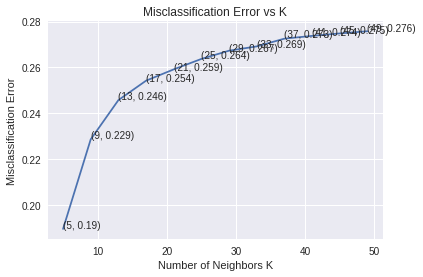

the misclassification error for each k value is :  [0.19  0.229 0.246 0.254 0.259 0.264 0.267 0.269 0.273 0.274 0.275 0.276]

the accuracy score for each k value is :  [0.81  0.771 0.754 0.746 0.741 0.736 0.733 0.731 0.727 0.726 0.725 0.724]


5

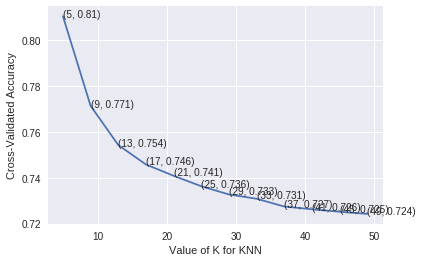

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

optimal_k = clf_brute(X_train, y_train)
optimal_k

In [0]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on test set: 70.561%
Precision on test set: 0.875
Recall on test set: 0.747
F1-Score on test set: 0.806


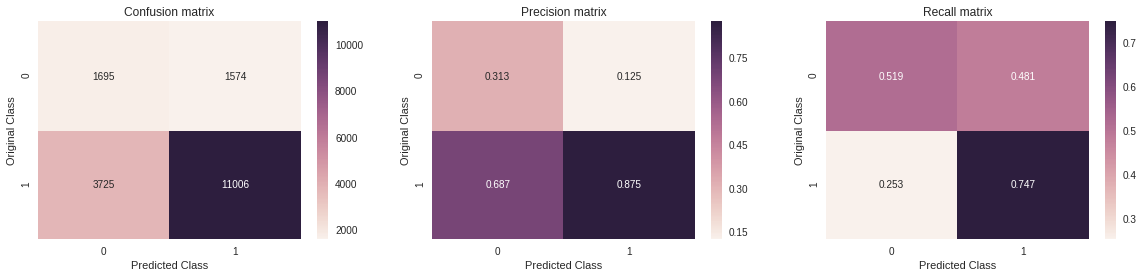

In [62]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.3] KNN with kd_tree algorithm

In [0]:
# Fuction to compute k value
def clf_kdtree(x_train, y_train):
    k = list(range(3,50,4))
    neighbors = list(filter(lambda x: x % 2 != 0, k))
    cv_scores = []

    # 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
        scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())

    # misclassification error
    MSE = [1 - x for x in cv_scores]

    # optimal k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of K is %d.' % optimal_k)

    # ploting misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
               
    # ploting accuracy vs k
    plt.plot(neighbors, cv_scores)
    for xy in zip(neighbors, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
   
  
    print("the misclassification error for each k value is : ", np.round(MSE,3))
    print("")
    print("the accuracy score for each k value is : ", np.round(cv_scores,3))
    return optimal_k


The optimal number of K is 3.


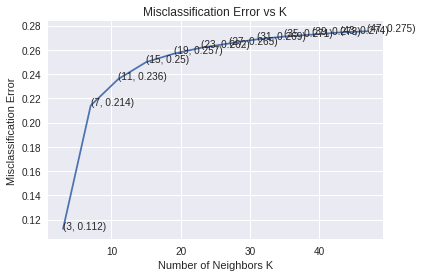

the misclassification error for each k value is :  [0.112 0.214 0.236 0.25  0.257 0.262 0.265 0.269 0.271 0.273 0.274 0.275]

the accuracy score for each k value is :  [0.888 0.786 0.764 0.75  0.743 0.738 0.735 0.731 0.729 0.727 0.726 0.725]


3

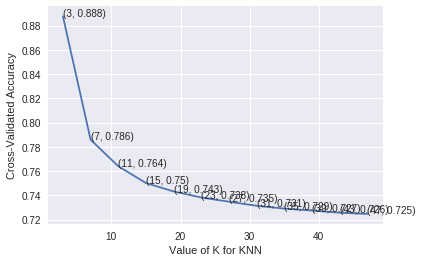

In [64]:
optimal_k = clf_kdtree(X_train, y_train)
optimal_k

Accuracy on test set: 77.050%
Precision on test set: 0.853
Recall on test set: 0.869
F1-Score on test set: 0.861


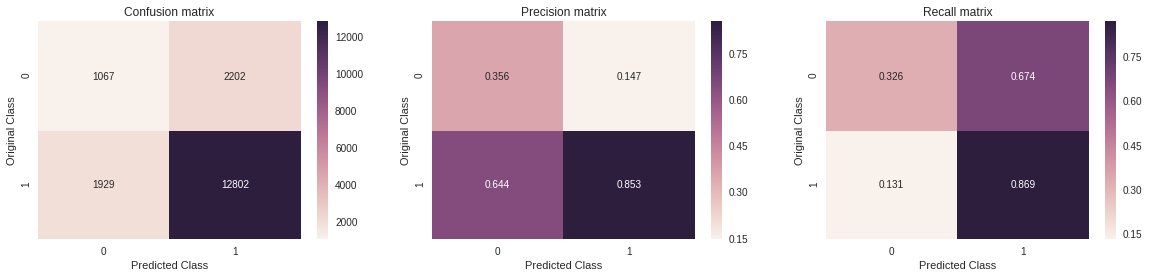

In [65]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [5] TF_IDF Featurization

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [67]:
from sklearn import preprocessing
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000) 

X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (42000, 2000)
Test Data Size:  (18000, 2000)


In [68]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 35758
Before OverSampling, counts of label '0': 6242 



## [5.1] Upsampling

In [69]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (71516, 2000)
After OverSampling, the shape of train_y: (71516,) 

After OverSampling, counts of label '1': 35758
After OverSampling, counts of label '0': 35758


## [5.2] KNN with brute force algorithm


The optimal number of K is 5.


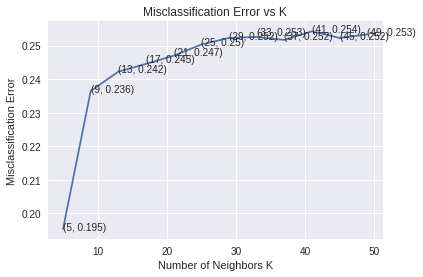

the misclassification error for each k value is :  [0.195 0.236 0.242 0.245 0.247 0.25  0.252 0.253 0.252 0.254 0.252 0.253]

the accuracy score for each k value is :  [0.805 0.764 0.758 0.755 0.753 0.75  0.748 0.747 0.748 0.746 0.748 0.747]


5

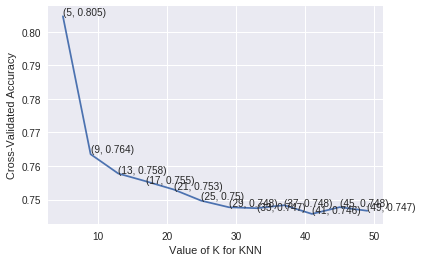

In [70]:
optimal_k = clf_brute(X_train, y_train)
optimal_k


Accuracy on test set: 70.828%
Precision on test set: 0.890
Recall on test set: 0.734
F1-Score on test set: 0.805


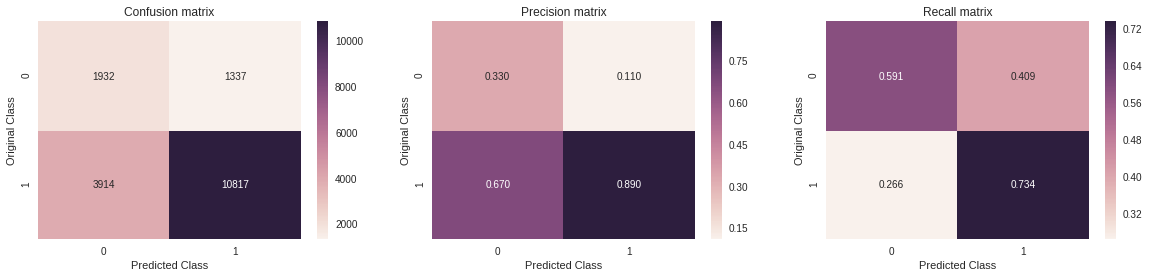

In [71]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.3] KNN with kd_tree algorithm


The optimal number of K is 3.


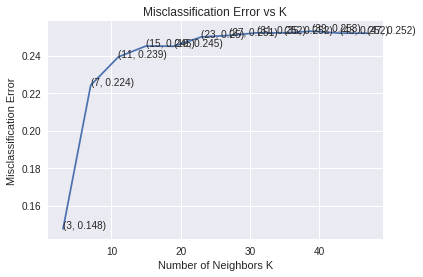

the misclassification error for each k value is :  [0.148 0.224 0.239 0.245 0.245 0.25  0.251 0.252 0.252 0.253 0.252 0.252]

the accuracy score for each k value is :  [0.852 0.776 0.761 0.755 0.755 0.75  0.749 0.748 0.748 0.747 0.748 0.748]


3

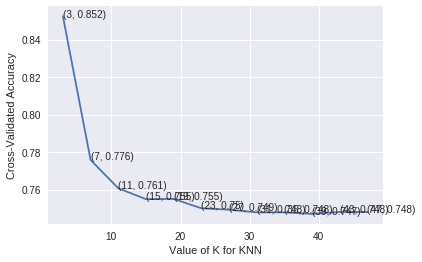

In [72]:
optimal_k = clf_kdtree(X_train, y_train)
optimal_k


Accuracy on test set: 74.422%
Precision on test set: 0.877
Recall on test set: 0.800
F1-Score on test set: 0.837


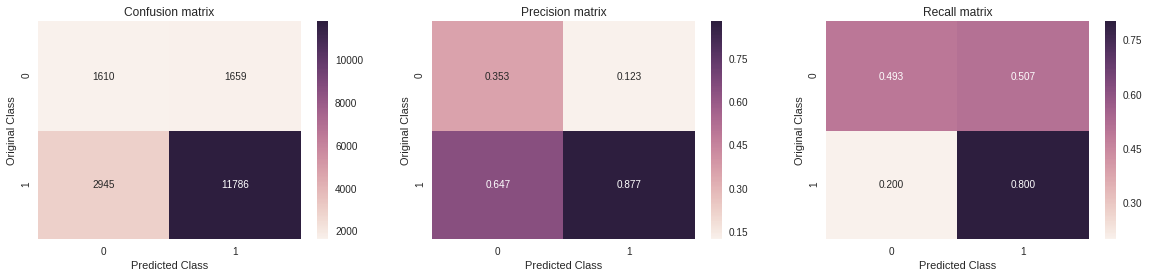

In [73]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [6] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [75]:
print(data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

bought apart infest fruit fli hour trap mani fli within day practic gone may long term solut fli drive crazi consid buy one surfac sticki tri avoid touch
*****************************************************************
['bought', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'fli', 'within', 'day', 'practic', 'gone', 'may', 'long', 'term', 'solut', 'fli', 'drive', 'crazi', 'consid', 'buy', 'one', 'surfac', 'sticki', 'tri', 'avoid', 'touch']


In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [77]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10169
sample words  ['bought', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'within', 'day', 'practic', 'gone', 'may', 'long', 'term', 'solut', 'drive', 'crazi', 'consid', 'buy', 'one', 'surfac', 'sticki', 'tri', 'avoid', 'touch', 'get', 'realli', 'imposs', 'today', 'find', 'french', 'version', 'film', 'could', 'pleas', 'tell', 'someth', 'sick', 'nasti', 'toothpick', 'counter', 'tint', 'concept', 'overdu', 'except', 'welcom', 'color', 'vibrant', 'offens']


# [7] Avg Word2Vec

In [78]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [01:23<00:00, 718.31it/s]

60000
50


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

In [80]:

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 35758
Before OverSampling, counts of label '0': 6242 



## [7.1] Upsampling

In [81]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (71516, 50)
After OverSampling, the shape of train_y: (71516,) 

After OverSampling, counts of label '1': 35758
After OverSampling, counts of label '0': 35758


## [7.2] KNN with brute force algorithm


The optimal number of K is 5.


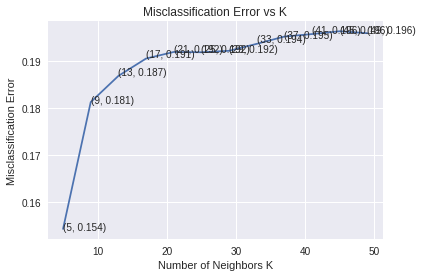

the misclassification error for each k value is :  [0.154 0.181 0.187 0.191 0.192 0.192 0.192 0.194 0.195 0.196 0.196 0.196]

the accuracy score for each k value is :  [0.846 0.819 0.813 0.809 0.808 0.808 0.808 0.806 0.805 0.804 0.804 0.804]


5

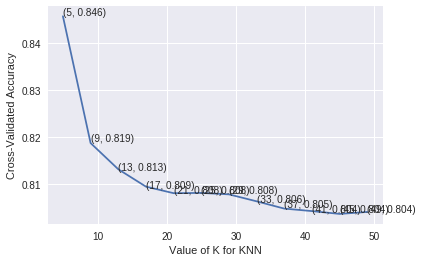

In [82]:
optimal_k = clf_brute(X_train, y_train)
optimal_k


Accuracy on test set: 76.867%
Precision on test set: 0.922
Recall on test set: 0.784
F1-Score on test set: 0.847


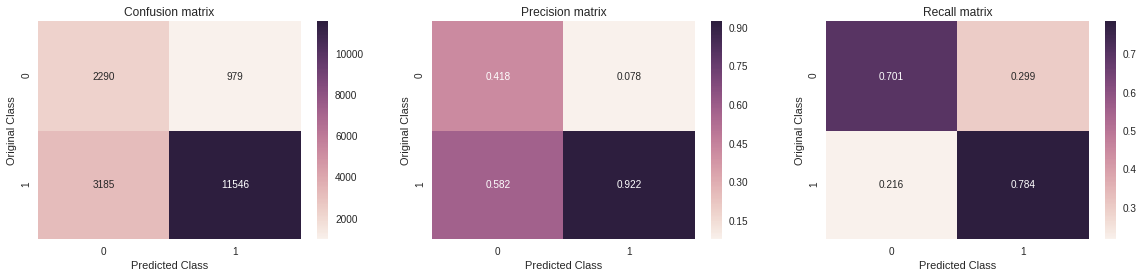

In [83]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [7.3] KNN with kd tree algorithm


The optimal number of K is 3.


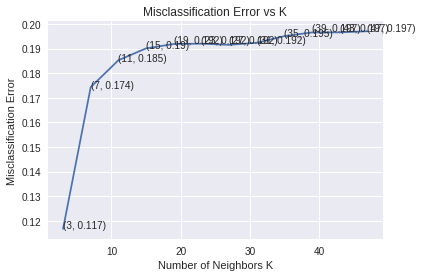

the misclassification error for each k value is :  [0.117 0.174 0.185 0.19  0.192 0.192 0.192 0.192 0.195 0.197 0.197 0.197]

the accuracy score for each k value is :  [0.883 0.826 0.815 0.81  0.808 0.808 0.808 0.808 0.805 0.803 0.803 0.803]


3

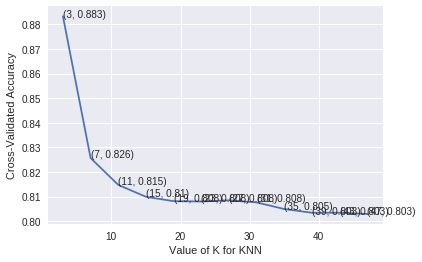

In [84]:
optimal_k = clf_kdtree(X_train, y_train)
optimal_k


Accuracy on test set: 79.589%
Precision on test set: 0.906
Recall on test set: 0.838
F1-Score on test set: 0.870


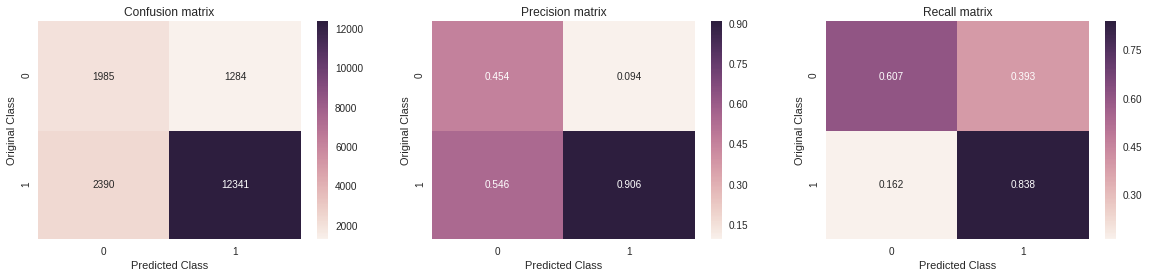

In [85]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [8] TF-IDF Word2Vec

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [87]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [01:52<00:00, 533.90it/s]


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

In [89]:

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 35758
Before OverSampling, counts of label '0': 6242 



## [8.1] Upsampling

In [90]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (71516, 50)
After OverSampling, the shape of train_y: (71516,) 

After OverSampling, counts of label '1': 35758
After OverSampling, counts of label '0': 35758


## [8.2] KNN with brute force algorithm


The optimal number of K is 5.


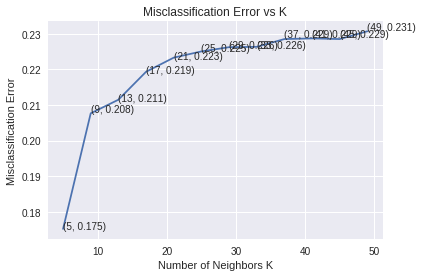

the misclassification error for each k value is :  [0.175 0.208 0.211 0.219 0.223 0.225 0.226 0.226 0.229 0.229 0.229 0.231]

the accuracy score for each k value is :  [0.825 0.792 0.789 0.781 0.777 0.775 0.774 0.774 0.771 0.771 0.771 0.769]


5

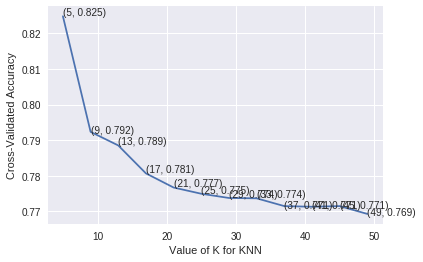

In [91]:
optimal_k = clf_brute(X_train, y_train)
optimal_k


Accuracy on test set: 72.928%
Precision on test set: 0.905
Recall on test set: 0.748
F1-Score on test set: 0.819


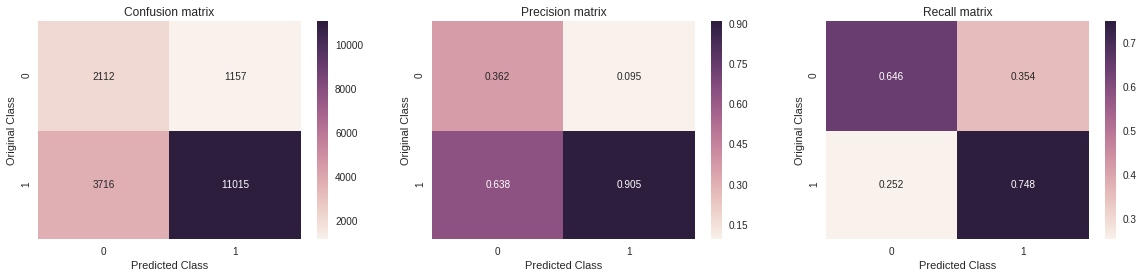

In [92]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [8.3] KNN with kd tree algorithm


The optimal number of K is 3.


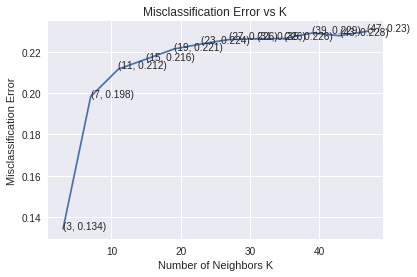

the misclassification error for each k value is :  [0.134 0.198 0.212 0.216 0.221 0.224 0.226 0.226 0.226 0.229 0.228 0.23 ]

the accuracy score for each k value is :  [0.866 0.802 0.788 0.784 0.779 0.776 0.774 0.774 0.774 0.771 0.772 0.77 ]


3

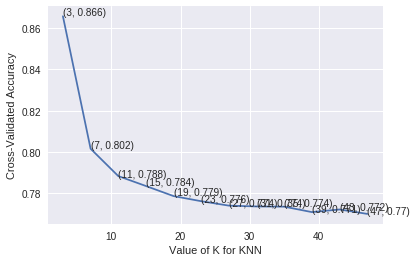

In [93]:
optimal_k = clf_kdtree(X_train, y_train)
optimal_k


Accuracy on test set: 76.167%
Precision on test set: 0.890
Recall on test set: 0.809
F1-Score on test set: 0.847


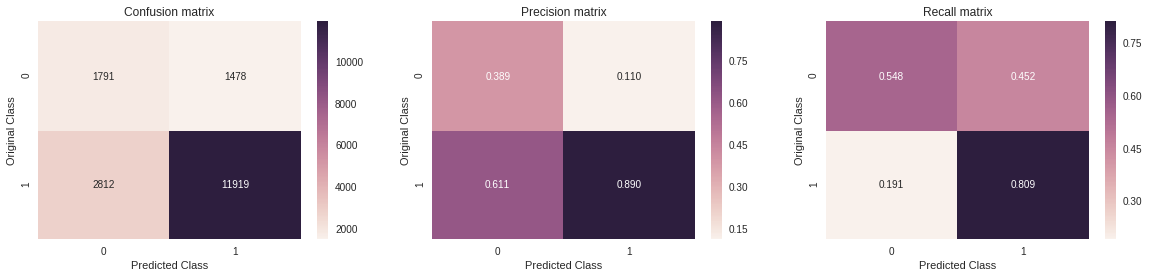

In [94]:
# KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
knn.fit(X_train, y_train)

#Accuracy on Test data
y_pred = knn.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# Performance Table

![image](https://i.ibb.co/0y0B2KN/Untitled.png)

# Conclusions

Note: As I have taken only 60k points(due to 4 GB RAM and huge training time)



1.   KNN is a very slow Algorithm takes very long time to train.
2.   Best Accuracy  is achieved by Avg Word2Vec Featurization which is of 79.789%.
3.   Both kd-tree and brute algorithms of KNN gives comparatively similar results.
4.   Overall KNN was not that good for this dataset.
